### Purpose: To obtain object statistics from impages imported by user

*To do List:*
4. Extract Basic Statistics:
Euler number
Image Centroids
On Both Object Areas and distances from object centroids to the image centroid
Min 
Max
Mean
Median
Variance
10-bin histogram 

*Decided to do a global threshold and a local threshold * - do more research into the difference between these two things

*Step 1: Import the necessary packages*

In [157]:
from PIL import Image, ImageFilter, ImageEnhance
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import scipy
from scipy.ndimage import gaussian_filter
import ObjectStats
from skimage import filters
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage import measure
from skimage import morphology
from scipy import ndimage
from skimage import segmentation
import preprocessing

*Step 2: User controlled inputs*

*Step 3: Image Import*

In [234]:
im =  Image.open("/Users/HawleyHelm/Desktop/P35_LPS_ipsi_40x_zstack_cells_MaxIP.png")

*Step 4: Splitting image into red, green, blue values*

In [259]:
r,g,b = im.split()

In [352]:
image = np.array(g)

In [353]:
contrast_image = preprocessing.im_contrast(image, 10)

In [354]:
contrast_image_arr = np.array(contrast_image)

__Step 4: Otsu Global Threshold*__ 

In [355]:
thresh = filters.threshold_otsu(contrast_image_arr)
thresh

99

*Step 5: Obtaining the Binary Mask of the image*

In [356]:
binary = image > thresh

*Step 6: Finding the eight connection items in the binary mask*

__Step 4: Local Threshold__

Question for me: how do you figure out what block size to use in local thresholding? - seems like i could easily introduce bias here

In [357]:
block_size = 35
adaptive_thresh = filters.threshold_local(contrast_image_arr, block_size, offset=10)
binary_adaptive = image > adaptive_thresh

*Step 5: Find all eight connection items in the binary mask*

In [358]:
distance = ndimage.distance_transform_edt(binary_adaptive)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=binary)

In [359]:
markers = morphology.label(local_maxi)
markers[~binary] = -1

In [360]:
labels_rw = segmentation.random_walker(binary, markers)

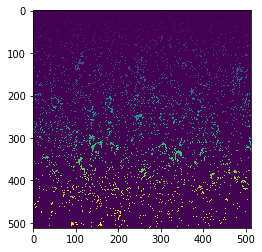

In [361]:
plt.imshow(labels_rw) 

*Step 5: Object labeling with local Threshold*

In [362]:
distance = ndimage.distance_transform_edt(binary_adaptive)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=binary_adaptive)

In [363]:
markers = morphology.label(local_maxi)
markers[~binary_adaptive] = -1

In [364]:
labels_rw_adaptive = segmentation.random_walker(binary_adaptive, markers)

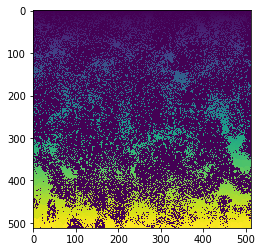

In [365]:
plt.imshow(labels_rw_adaptive) 

*Step 6: Extract Basic Statistics*

In [231]:
properties = measure.regionprops(labels_rw)
[prop.perimeter for prop in properties] 

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 3.414213562373095,
 3.414213562373095,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 4.621320343559642,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 3.414213562373095,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 3.414213562373095,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 5.449747468305834,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 4.0,
 0.0,
 0.0,
 6.82842712474619,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 5.0,
 0.0,
 0.0,
 0.0,
 4.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 3.414213562373095,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 